In [5]:
import pandas as pd
import os
from pathlib import Path

In [15]:
## Year, State, Recipiency Rate -> recipiency.csv
create_recipiency()

In [14]:
def create_recipiency():
    
    # Path to folder
    cwd = os.getcwd()
    folder_path = Path(cwd + "/raw")

    # List to store individual DataFrames
    dfs = []

    # Loop through all Excel files
    for file in folder_path.glob("*.csv"):
        df = pd.read_csv(file)
        dfs.append(df)

    # Append all rows together
    final_df = pd.concat(dfs, ignore_index=True)
    final_df = final_df.dropna()
    final_df = final_df.sort_values(by=["Year", "State"], ascending=True)
    final_df = final_df.rename(columns={"Insured Unemployment": "Recipiency Rate"})

    us_df = final_df[final_df["State"] == "US"]
    final_df = final_df[final_df["State"] != "US"]


    final_df.to_csv("recipiency.csv", index=False)
    us_df.to_csv("us_recipiency.csv", index=False)
    
    return

## Figure: Changes in Recipiency Rates between AWW WBA Max Indexers vs. Non-Indexers from 2004-2024

In [49]:
master = pd.read_csv("[2004, 2024]base_master_versionDec2025.csv")
indexers_list = ['AR', 'CO', 'CT', 'DC', 'HI', 'IA', 'ID', 'IL', 'KS', 'KY', 'LA', 'MA', 'ME', 'MN', 'MT', 'NC', 'ND', 'NJ', 'NM', 'NV', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'UT', 'VT', 'WA', 'WV', 'WY']
nonindexers_list = ['AK', 'AL', 'AZ', 'CA', 'DE', 'FL', 'GA', 'IN', 'MD', 'MI', 'MO', 'MS', 'NH', 'NY', 'TN', 'VA', 'WI']
len(indexers_list), len(nonindexers_list)

(33, 17)

In [50]:
master.columns

Index(['Year', 'State', 'Region', 'Average WBA', 'Maximum WBA', 'Minimum WBA',
       'Average Weekly Wage', 'Indexer', 'Non-indexer', 'Recipiency Rate',
       'Replacement Ratio 1', 'Replacement Ratio 2', 'National CPI-U',
       'Regional CPI-U', 'Real Average WBA (base 2004, region)',
       'Real Maximum WBA (base 2004, region)',
       'Real Average WBA (base 2004, nation)',
       'Real Maximum WBA (base 2004, nation)',
       'Real Average WBA (base 2024, region)',
       'Real Maximum WBA (base 2024, region)',
       'Real Average WBA (base 2024, nation)',
       'Real Maximum WBA (base 2024, nation)'],
      dtype='object')

In [83]:
master = master[master['Year'] >= 2004]
indexers = master[master['State'].isin(indexers_list)]
nonindexers = master[master['State'].isin(nonindexers_list)]

In [84]:
avg_indexers = indexers.groupby(['Year'])[['Recipiency Rate']].aggregate('mean').round(2)
avg_indexers = avg_indexers.reset_index()
avg_indexers.head()

,Year,Recipiency Rate
0,2004,0.36
1,2005,0.34
2,2006,0.34
3,2007,0.36
4,2008,0.38


In [85]:
avg_nonindexers = nonindexers.groupby(['Year'])[['Recipiency Rate']].aggregate('mean').round(2)
avg_nonindexers = avg_nonindexers.reset_index()
avg_nonindexers.head()

,Year,Recipiency Rate
0,2004,0.35
1,2005,0.33
2,2006,0.34
3,2007,0.35
4,2008,0.36


In [86]:
avg_indexers['Recipiency Rate'] = (avg_indexers['Recipiency Rate'] - 0.36) / 0.36 * 100
#avg_indexers = avg_indexers[~avg_indexers["Year"].isin([2020, 2021])]
avg_indexers = avg_indexers.reset_index()

In [87]:
avg_nonindexers['Recipiency Rate'] = (avg_nonindexers['Recipiency Rate'] - 0.35) / 0.35 * 100
#avg_nonindexers = avg_nonindexers[~avg_nonindexers["Year"].isin([2020, 2021])]
avg_nonindexers = avg_nonindexers.reset_index()

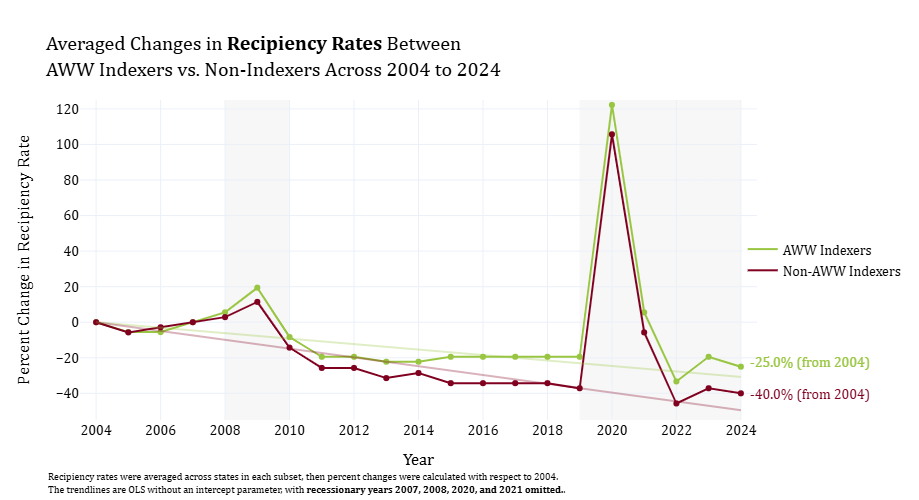

In [106]:
pio.templates.default = 'plotly_white'

avg_indexers_minus_rec = avg_indexers[~avg_indexers["Year"].isin([2008, 2009, 2020, 2021])]
X = avg_indexers_minus_rec["index"]
y = avg_indexers_minus_rec["Recipiency Rate"]

X_reshaped = X.values.reshape(-1, 1)
model = sm.OLS(y, X, hasconst=False).fit()

x_pred = np.linspace(X.min(), X.max(), 100)
y_pred = model.predict(x_pred)
x_pred = x_pred + 2004

avg_nonindexers_minus_rec = avg_nonindexers[~avg_nonindexers["Year"].isin([2008, 2009, 2020, 2021])]
X = avg_nonindexers_minus_rec["index"]
y = avg_nonindexers_minus_rec["Recipiency Rate"]

X_reshaped = X.values.reshape(-1, 1)
model = sm.OLS(y, X, hasconst=False).fit()

x_pred2 = np.linspace(X.min(), X.max(), 100)
y_pred2 = model.predict(x_pred2)
x_pred2 = x_pred2 + 2004

fig3 = px.line(data_frame = avg_indexers, 
             x = "Year", 
             y = "Recipiency Rate")
fig3.update_traces(line=dict(color = '#99C642'), name="AWW Indexers", showlegend=True)

fig4= px.scatter(data_frame = avg_indexers, 
                x = "Year", 
                y = "Recipiency Rate",
                color_discrete_sequence=["#99C642"])

fig7 = px.line(data_frame = avg_nonindexers, 
             x = "Year", 
             y = "Recipiency Rate")
fig7.update_traces(line=dict(color = '#800020'), name="Non-AWW Indexers", showlegend=True)

fig8= px.scatter(data_frame = avg_nonindexers, 
                x = "Year", 
                y = "Recipiency Rate",
                color_discrete_sequence=["#800020"])

fig3 = go.Figure(data= fig3.data + fig4.data + fig7.data + fig8.data)

fig3.add_trace(go.Scatter(
    x=x_pred,
    y=y_pred,
    mode='lines',
    line=dict(color='#99C642', width=2),
    opacity=0.3,
    showlegend=False
))
fig3.add_trace(go.Scatter(
    x=x_pred2,
    y=y_pred2,
    mode='lines',
    line=dict(color='#800020', width=2),
    opacity=0.3,
    showlegend=False
))


fig3.update_layout(title_text="Averaged Changes in <b>Recipiency Rates</b> Between<br>AWW Indexers vs. Non-Indexers Across 2004 to 2024",
                   xaxis_title="Year", yaxis_title="Percent Change in Recipiency Rate",
                   height=500,
                   font=dict(
                        family="Cambria",  
                        size=14,         
                        color="black",
                    ),
                   xaxis=dict(
                        range=[2003.5, 2024.5],
                        tickmode="linear",
                        tick0=2004,
                        dtick=2
                    ),
                   yaxis=dict(
                        range=[-55, 125],  
                        tick0=0,
                        dtick=20,
                        zeroline=False,
                        zerolinewidth=1,
                        zerolinecolor="black"
                    ),
                   legend=dict(
                        orientation="v",     
                        x=1.1,
                        xanchor="center",
                        y=0.5
                    )
                  )
fig3.add_annotation(
    xref="paper", yref="paper",
    x=1.17, y=0.15,
    text="-25.0% (from 2004)",
    showarrow=False,
    font=dict(size=14, color="#99C642"),
    align="left"
)
fig3.add_annotation(
    xref="paper", yref="paper",
    x=1.17, y=0.05,
    text="-40.0% (from 2004)",
    showarrow=False,
    font=dict(size=14, color="#800020"),
    align="left"
)
fig3.add_annotation(
    text='Recipiency rates were averaged across states in each subset, then percent changes were calculated with respect to 2004.<br>The trendlines are OLS without an intercept parameter, with <b>recessionary years 2007, 2008, 2020, and 2021 omitted.</b>.',
    showarrow=False,
    xref="paper",
    yref="paper",
    x=-0.05,
    y=-0.15,
    xanchor="left",
    yanchor="top",
    font=dict(size=10),
    align="left"
)
fig3.add_vrect(
    x0=2019,
    x1=2024,   
    fillcolor="rgba(200, 200, 200, 0.15)",
    layer="below",
    line_width=0
)
fig3.add_vrect(
    x0=2008,
    x1=2010,   
    fillcolor="rgba(200, 200, 200, 0.15)",
    layer="below",
    line_width=0
)